# Spatial data processing

*Spatial data processing* (or *geoprocessing*) is the use of tools and functions to analyze and manipulate geographic data, often to create new data or information. 

It's like doing applied math on map data — combining, measuring, or filtering spatial data to get new information. Here are a couple of examples:

- *Buffer*: Creating a zone around a feature, like drawing a 1km area around a school.

- *Clip*: Cutting one layer by the shape of another, like trimming land-use data to the boundary of a city.

These help answer spatial questions like “What’s within walking distance?” or “How much green-space is inside this area?” or "How many libraries are in each neighbourhood?"

There are many ways to interact with spatial data - ranging from getting geometric points from addresses, to intersecting different spatial datasets. In this notebook, we'll cover a number of commonly used spatial data processing functions. 

We'll show the examples using `geopandas`, however every one of these examples can easily be done in GIS software and many other libraries for working with spatial data.


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

Let's remind ourselves of some key concepts to start with. For a broader overview, check out our notebook on [Spatial data and GIS](../spatial-data-and-gis/spatial-data-and-gis.md).

First, there are two major types of spatial data.

 - *Vector* data represents geographic features as discrete points, lines, and polygons, making it ideal for boundaries, roads, or point locations like cities.

 - *Raster* data stores information in a grid of pixels (cells), often used for continuous data like elevation models or satellite imagery.

In this notebook, we'll mostly be working with vector data, which consists of three common types of geometry.

 1. *Points* are zero-dimensional coordinates (e.g., a library’s latitude/longitude).

 2. *Lines* are one-dimensional sequences of points (e.g., rivers, roads, or transit routes).

 3. *Polygons* are two-dimensional enclosed shapes (e.g., political boundaries, lakes, or census tracts).

These can be projected into different [Coordinate Reference Systems (CRS)](https://en.wikipedia.org/wiki/Spatial_reference_system), which define how spatial data maps to the Earth’s surface. For example, WGS84 (EPSG:4326) is common for global latitude/longitude coordinates, while UTM zones (e.g., EPSG:32617) minimize distortion for local measurements. 

Choosing the right CRS ensures accurate distances, areas, and spatial relationships.

When we are comparing and relating multiple spatial datasets to each other, we have to ensure that they are in the same CRS.

In order to process spatial data we will be working with three datasets today (you can also download them by clicking on the link):

 - Toronto Public Libraries (TPL) branches ([tpl-branch-general-information-2023.csv](https://github.com/schoolofcities/urban-data-storytelling/blob/main/notebooks/urban-data-analytics/spatial-data-processing/data/tpl-branch-general-information-2023.csv)), which contains information about each of the libraries in the TPL

 - Toronto's wards ([city-wards.gpkg](https://github.com/schoolofcities/urban-data-storytelling/blob/main/notebooks/urban-data-analytics/spatial-data-processing/data/city-wards.gpkg)), each of which have a city councillor
 
 - Toronto's regions ([toronto-regions.gpkg](https://github.com/schoolofcities/urban-data-storytelling/blob/main/notebooks/urban-data-analytics/spatial-data-processing/data/toronto-regions.gpkg)), which are the former municipalities that were amalgamated in 1998 to make modern Toronto

In [7]:
df_tpl = pd.read_csv('./data/tpl-branch-general-information-2023.csv')
gdf_wards = gpd.read_file('./data/city-wards.gpkg')
gdf_regions = gpd.read_file('./data/toronto-regions.gpkg')

## Geocoding

*Geocoding* converts addresses (e.g. `"100 Queen St, Toronto, ON M5H 2N2"`) into geographic coordinates (e.g. `[-79.3840, 43.6536]`) that can be plotted on a map and analyzed in GIS or Python.

Of course we could simply input the string for an address into Google Maps, search for it, and manually record the coordinate location. However, this wouldn't be practical if we had a big list of addresses. Let's take the `.csv` data that we loaded for library locations. There are 112 in Toronto!

In [8]:
df_tpl[["BranchName","Address"]]

,BranchName,Address
0,Albion,"1515 Albion Road, Toronto, ON, M9V 1B2"
1,Albert Campbell,"496 Birchmount Road, Toronto, ON, M1K 1N8"
2,Alderwood,"2 Orianna Drive, Toronto, ON, M8W 4Y1"
3,Agincourt,"155 Bonis Avenue, Toronto, ON, M1T 3W6"
4,Armour Heights,"2140 Avenue Road, Toronto, ON, M5M 4M7"
...,...,...
107,Woodview Park,"16 Bradstock Road, Toronto, ON, M9M 1M8"
108,Woodside Square,"Woodside Square Mall, 1571 Sandhurst Circle, T..."
109,Wychwood,"1431 Bathurst Street, Toronto, ON, M5R 3J2"
110,Yorkville,"22 Yorkville Avenue, Toronto, ON, M4W 1L4"


A geocoding function, either in Python or GIS, typically relies on an external *geocoder*, a service that turns addresses or place names into map coordinates. Large companies like Google, Apple, and Mapbox provide geocoding services. However, these require an API key and often have a tiered pricing model. There are free tools as well, for example [Nominatim](https://nominatim.org/) which queries OpenStreetMap’s database. This is what we will use in this notebook.

In `geopandas`, the [function for geocoding](https://geopandas.org/en/stable/docs/reference/api/geopandas.tools.geocode.html) is `geopandas.tools.geocode()`. This transforms a DataFrame of addresses into a GeoDataFrame with `Point` geometries, enabling spatial analysis.

There are [similar tools in QGIS](https://gisgeography.com/qgis-geocoding/) which make use of geocoders like Nominatim and others.

Free geocoding services usually allow about one query per second, regardless of whether you are accessing them in QGIS or Python. **Try running the code below.** Since we have over 100 library branches, you'll have to wait a little bit! :)

In [ ]:
gdf_tpl = gpd.tools.geocode(
    df_tpl["Address"],  
    provider="nominatim",      
    user_agent="tpl-workshop",
    timeout=10
)

# Add in and update columns
gdf_tpl['Address'] = df_tpl['Address']
gdf_tpl['BranchName'] = df_tpl['BranchName']
gdf_tpl = gdf_tpl.drop(columns=['address'])
gdf_tpl = gdf_tpl.to_crs(4326)

In [9]:
## In case you don't want to run and wait for the geocoding to work, we've precomputed it and you can load
gdf_tpl = gpd.read_file('./data/tpl.gpkg')

In [10]:
gdf_tpl.head()

,Address,BranchName,geometry
0,"1515 Albion Road, Toronto, ON, M9V 1B2",Albion,POINT (-79.58481 43.73987)
1,"496 Birchmount Road, Toronto, ON, M1K 1N8",Albert Campbell,POINT (-79.2693 43.70806)
2,"2 Orianna Drive, Toronto, ON, M8W 4Y1",Alderwood,POINT (-79.54724 43.60191)
3,"155 Bonis Avenue, Toronto, ON, M1T 3W6",Agincourt,POINT (-79.29345 43.78527)
4,"2140 Avenue Road, Toronto, ON, M5M 4M7",Armour Heights,POINT (-79.42171 43.73927)


Once we've geocoded the data, we can then map and analyze this data relative to other spatial data.

## Buffer

*Buffers* create zones around geometries at a specified distance.

For example, if we wanted to map the area that is within 1km of the nearest library, we would compute a buffer with the point locations of libraries as the input using [the function](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) `.buffer(N)` (or [accompanying methods in QGIS](https://docs.qgis.org/3.40/en/docs/gentle_gis_introduction/vector_spatial_analysis_buffers.html)).

Buffers can be super useful on their own, but they can also be important steps in analyses. For example, you could take buffers of library locations and then count the number of households within each buffer.

**Try running the code below to compute buffers for library locations. You can also test different buffer distances! :)**

In [11]:
# converts to UTM Zone 17, which is in metres
gdf_tpl = gdf_tpl.to_crs("EPSG:32617") 

# generate buffer at 1km (1000m)
gdf_tpl["buffer_1km"] = gdf_tpl.buffer(1000)

Great! let's see what this looks like

<Axes: >

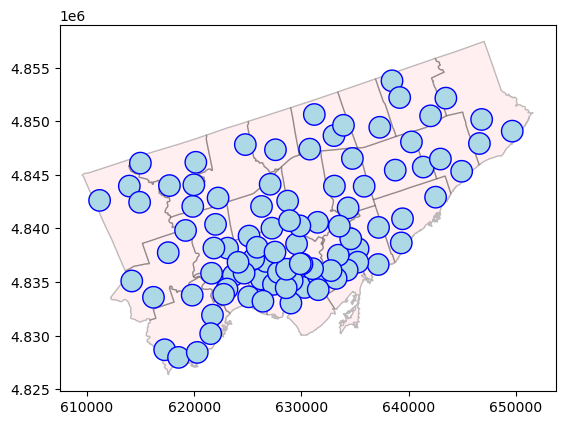

In [12]:
# Compare the wards and their center points
ax = gdf_wards.plot(alpha=0.25, edgecolor='black', color="pink", linewidth=1)
gdf_tpl.set_geometry("buffer_1km").plot(ax=ax, color="lightblue", edgecolor="blue")

## Dissolve

**Dissolve** merges multiple features into one, either based on a shared attribute or as a single unified shape.

You might have noticed that many of the buffered library polygons overlapped each other. We can use the method `.dissolve()` [from geopandas](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html#dissolve-example), to combine all of these polygons into a single polygon. Check out [this tutorial for a similar function in QGIS](https://www.geographyrealm.com/dissolve-features-attribute-qgis/).

In [ ]:
gdf_tpl_dissolved = gdf_tpl.set_geometry("buffer_1km").dissolve()

Let's plot it! Notice how all buffers that were overlapping are now merged into one much larger geometry.

In [ ]:
ax = gdf_wards.plot(alpha=0.25, edgecolor='black', color="pink", linewidth=1)
gdf_tpl_dissolved.plot(ax=ax, color="lightblue", edgecolor="blue")

Having this as one geometry can be useful for quick questions like asking how much of the city (in terms of area) is within 1km of a public library. If we did this calculation on just the buffered polygon, we would be double counting areas of overlap.

In [ ]:
# computing area of the dissolved polygon, dividing to covert to km2
gdf_tpl_dissolved.buffer_1km.area / (1000 * 1000)

## Centroids

*Centroids* are the geometric center point of polygons.

Computing centroids is useful for urban analyses because it gives a single representative point for each area, which is helpful for labeling, spatial joins, spatial selections, or other further processing of spatial data. For example, we could compute the centroid of each ward in Toronto, and then try to find the closest hospital to each.

In `geopandas` we can use [the method](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.centroid.html) `.centroid` to return a Point geometry for each feature. Here's a quick example of finding the centroids of Toronto wards. [QGIS also has a centroids function](https://docs.qgis.org/3.40/en/docs/user_manual/processing_algs/qgis/vectorgeometry.html#centroids).

<Axes: >

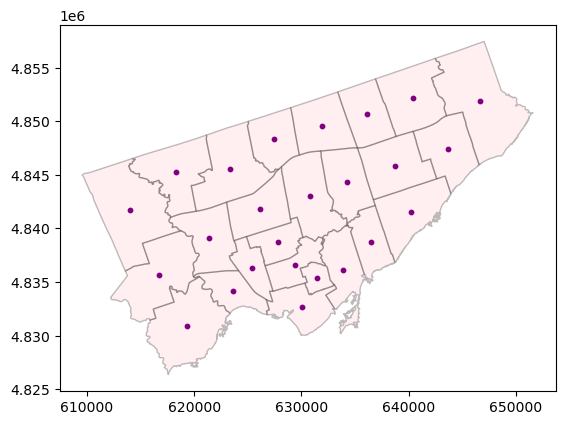

In [13]:
# Convert to UTM Zone 17N (meters)  
gdf_wards = gdf_wards.to_crs("EPSG:32617")  

# Compute centroids (as Point geometries)  
gdf_wards["centroid"] = gdf_wards.centroid  

# Compare the wards and their center points
ax = gdf_wards.plot(alpha=0.25, edgecolor='black', color="pink", linewidth=1)
gdf_wards.set_geometry("centroid").plot(ax=ax, color="purple", markersize=10)

## Spatial Selections

*Spatial selections*, or *spatial queries*, are ways we can filter datasets based on their locations relative to other spatial features and datasets.

This can have a wide variety of applications. For example, you can filter ...

- Library locations that are within a given neighbourhood
- Schools that are within a set distance of an expressway
- Streets that cross railroad tracks
- Parks that contain baseball fields
- And more!

Below, we'll show an example with `geopandas`, selecting libraries that are within a neighbourhood.

([Check out this video tutorial for doing similar selections in QGIS](https://www.youtube.com/watch?v=zoElYnD2G5o))

Let's begin by loading in the data, and convert to a common CRS so the data can be related to each other accurately.

In [14]:
gdf_tpl = gpd.read_file('./data/tpl.gpkg').to_crs("EPSG:32617") 
gdf_regions = gpd.read_file('./data/toronto-regions.gpkg').to_crs("EPSG:32617") 

The `gdf_regions` are the 6 former municipalities of Toronto prior to amalgamation.

In [15]:
gdf_regions

,REGION_NAME,geometry
0,YORK,"MULTIPOLYGON (((621566.778 4833819.469, 621576..."
1,NORTH YORK,"MULTIPOLYGON (((617962.54 4840496.385, 617956...."
2,EAST YORK,"MULTIPOLYGON (((637991.822 4838842.675, 637885..."
3,SCARBOROUGH,"MULTIPOLYGON (((637991.822 4838842.675, 637977..."
4,ETOBICOKE,"MULTIPOLYGON (((622510.211 4830645.811, 622497..."
5,TORONTO,"MULTIPOLYGON (((629370.742 4831174.941, 629343..."


Lets try to query our dataset of public library locations to find only those within `SCARBOROUGH`, via `.intersects`

In [16]:
# Get Scarborough's polygon from regions  
scarborough = gdf_regions[gdf_regions["REGION_NAME"] == "SCARBOROUGH"].geometry.iloc[0]  

# filter the library dataset via a spatial selection, specifically .intersects
gdf_tpl[gdf_tpl.intersects(scarborough)]

,Address,BranchName,geometry
1,"496 Birchmount Road, Toronto, ON, M1K 1N8",Albert Campbell,POINT (639436.969 4840903.999)
3,"155 Bonis Avenue, Toronto, ON, M1T 3W6",Agincourt,POINT (637314.699 4849438.607)
10,"1515 Danforth Road, Toronto, ON, M1J 1H5",Bendale,POINT (641371.584 4845728.55)
18,"1081 Progress Avenue, Toronto, ON, M1B 5Z6",Burrows Hall,POINT (642055.158 4850504.516)
19,"3017 Kingston Road, Toronto, ON, M1M 1P1",Cliffcrest,POINT (642523.048 4842918.563)
21,"545 Markham Road, Toronto, ON, M1H 2A1",Cedarbrae,POINT (642971.873 4846476.537)
43,"295 Alton Towers Circle, Toronto, ON, M1V 4P1",Goldhawk Park,POINT (638458.503 4853772.851)
44,"Guildwood Plaza, 123 Guildwood Parkway, Toront...",Guildwood,POINT (644952.92 4845333.931)
46,"3550 Ellesmere Road, Toronto, ON, M1C 3Z2",Highland Creek,POINT (646818.591 4850167.812)
63,"30 Sewells Road, Toronto, ON, M1B 3G5",Malvern,POINT (643480.9 4852157.674)


If we wanted to simply count the number of libraries in Scarborough, we can do that too!

In [17]:
len(gdf_tpl[gdf_tpl.intersects(scarborough)])

16

`.intersects` is just one of several spatial selection methods. Here's a list of several options in `.geopandas`. QGIS and other GIS software all have the same options, but they might just have different names.

| Method              | Description                                | Docs                                                                 |
|---------------------|--------------------------------------------|----------------------------------------------------------------------|
| `intersects()`      | Returns `True` if geometries intersect     | [intersects](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.intersects.html) |
| `contains()`        | `True` if geometry completely contains the other | [contains](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.contains.html)     |
| `within()`          | `True` if geometry is within another       | [within](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.within.html)         |
| `crosses()`         | `True` if geometry crosses the other       | [crosses](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.crosses.html)       |
| `overlaps()`        | `True` if geometries partially overlap     | [overlaps](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.overlaps.html)     |
| `touches()`         | `True` if geometries touch at boundary only| [touches](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.touches.html)       |
| `equals()`          | `True` if geometries are exactly equal     | [equals](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.equals.html)         |
| `disjoint()`        | `True` if geometries have no overlap at all| [disjoint](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.disjoint.html)     |
| `covers()`          | `True` if geometry covers the other        | [covers](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.covers.html)         |
| `covered_by()`      | `True` if geometry is covered by the other | [covered_by](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.covered_by.html) |
| `distance()`        | Returns distance to the other geometry     | [distance](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.distance.html)     |

## Spatial Joins

*Spatial joins* combine data from two spatial datasets based on their spatial (i.e. geographic) relationship, allowing you to connect attributes from different layers. This is similar to a table join, but instead of joining data based tabular data (e.g. matching ID columns), we are joining data based on spatial relationships.

For example, you can match points (libraries) to polygons (wards) to see which administrative district contains each facility. And further, count how many libraries are in each.

This is similar to doing spatial selections and queries, but instead of filtering one of our input datasets, we are creating a new dataset.

We'll show an example in `geopandas` but checkout [this tutorial for doing spatial joins in QGIS](https://www.qgistutorials.com/en/docs/3/performing_spatial_joins.html)

In [18]:
crs = "EPSG:32617"
gdf_tpl = gpd.read_file('./data/tpl.gpkg').to_crs(crs) 
gdf_regions = gpd.read_file('./data/toronto-regions.gpkg').to_crs(crs) 

We'll begin by trying to join region names to library locations.

We can do this using the [geopandas method](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) `.sjoin()` (see [similar documentation for QGIS](https://www.qgistutorials.com/en/docs/performing_spatial_joins.html)).

In [19]:
gdf_tpl_with_regions = gpd.sjoin(
    gdf_tpl, 
    gdf_regions[['REGION_NAME', 'geometry']], 
    how='left', 
    predicate='within'
)
gdf_tpl_with_regions.head()

,Address,BranchName,geometry,index_right,REGION_NAME
0,"1515 Albion Road, Toronto, ON, M9V 1B2",Albion,POINT (613956.686 4843954.713),4.0,ETOBICOKE
1,"496 Birchmount Road, Toronto, ON, M1K 1N8",Albert Campbell,POINT (639436.969 4840903.999),3.0,SCARBOROUGH
2,"2 Orianna Drive, Toronto, ON, M8W 4Y1",Alderwood,POINT (617250.27 4828684.997),4.0,ETOBICOKE
3,"155 Bonis Avenue, Toronto, ON, M1T 3W6",Agincourt,POINT (637314.699 4849438.607),3.0,SCARBOROUGH
4,"2140 Avenue Road, Toronto, ON, M5M 4M7",Armour Heights,POINT (627091.776 4844124.918),1.0,NORTH YORK


The parameter `predicate=` can be one of several options for spatial relationship noted in the above section (e.g. `.intersects`, `.within`, `.crosses`, etc.). The parameter `how=` is for the type of joining (e.g. left, inner, right, etc.)

View more in the [geopandas documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html#geopandas.GeoDataFrame.sjoin) page for spatial joins.

Doing a spatial join can then lead to a range of subsequent analyses, for example counting the number of libraries in each region. If you had numeric data, for example the number of books in each branch, the following count could be expanded to compute `sum`, `mean`, etc. for each group.

In [20]:
gdf_tpl_with_regions.groupby('REGION_NAME').size()

REGION_NAME
EAST YORK       4
ETOBICOKE      12
NORTH YORK     19
SCARBOROUGH    16
TORONTO        35
YORK            6
dtype: int64

## Overlay Operations

*Overlay* operations take two spatial datasets and produce a new one based on the spatial relationships between their geometries.

| Operation              | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| `intersection`         | Finds only the overlapping areas between two layers                         |
| `union`                | Merges all geometries from both layers into a single combined shape         |
| `symmetric_difference` | Keeps geometry that is in **either** layer but **not both**                 |
| `difference`           | Extracts parts of the **first** layer that are **not** covered by the second|


The image below is adapted from the [full tutorial](https://geopandas.org/en/stable/docs/user_guide/set_operations.html) in `geopandas` on this topic which you can look at for more details. QGIS also has [similar functions available](https://docs.qgis.org/3.40/en/docs/user_manual/processing_algs/qgis/vectoroverlay.html).

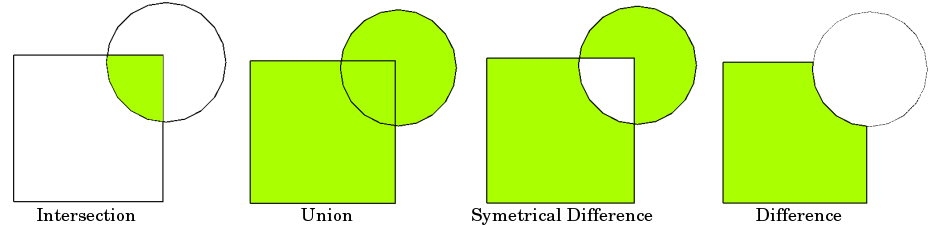

In `geopandas` these operations are performed using `gpd.overlay()` 

Let's take a look at a quick example, where we find the portions of wards in Toronto that overlap with the Old Toronto region area.

In [21]:
crs = 32617
gdf_wards = gpd.read_file('./data/city-wards.gpkg').to_crs(crs)
gdf_regions = gpd.read_file('./data/toronto-regions.gpkg').to_crs(crs)

<Axes: >

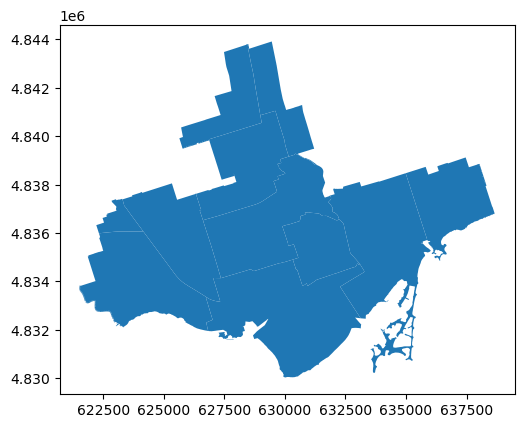

In [22]:
# Get Old Toronto polygon
old_toronto = gdf_regions[gdf_regions["REGION_NAME"] == "TORONTO"]

# Find intersecting wards
intersection = gpd.overlay(gdf_wards, old_toronto, how="intersection", keep_geom_type=False)

intersection.plot()

This has returned the portions of wards that overlap with the Old Toronto polygon.

By overlaying all the wards, we can see below that the orange area has been cut out 

<Axes: >

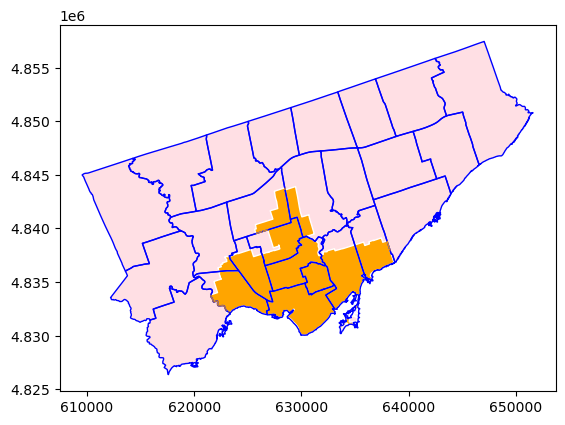

In [23]:
ax = gdf_wards.plot(alpha=0.5, edgecolor='white', color="pink", linewidth=1)
intersection.plot(ax=ax, edgecolor='white', color="orange", linewidth=1)
gdf_wards.plot(ax=ax, edgecolor='blue', color="none", linewidth=1)